In [1]:
import tensorflow as tf
import os
from glob import glob
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from IPython.core.display import display, HTML
import numpy as np
display(HTML("<style>.container { width:90% !important; }</style>"))
tf.keras.mixed_precision.set_global_policy("float32")

In [3]:
model = tf.keras.models.load_model("model1.h5")

In [7]:
from tensorflow.keras import backend as K

In [8]:
K.set_floatx("float32")
ws = model.get_weights()
wsp = [w.astype(K.floatx()) for w in ws]
model_quant = model1
model_quant.set_weights(wsp)
model.save("model_float32.h5")

In [2]:
model = tf.keras.models.load_model("model_float32.h5")
model

In [ ]:
tf.

In [6]:
model1.load_weights("model_float32.h5")
model1.save("model_float32.h5")

In [5]:
from tensorflow.keras import layers
model1 = tf.keras.Sequential([
    tf.keras.Input(shape = [4096,3]),
#         layers.Conv1D(kernel_size=12, filters=4,
#                        kernel_initializer=ownInitializer, input_shape=[4096,3], trainable=True, padding="same"),
    layers.Conv1D(kernel_size=4, filters=12, padding="same"),
#     layers.ZeroPadding1D(padding=[0,3]),
    layers.Reshape([4096,12,1]),
    layers.TimeDistributed(layers.Conv1D(kernel_size=3, filters=32, activation="tanh", padding="same")),
#     layers.TimeDistributed(layers.Conv1D(kernel_size=5, filters=32, activation="tanh", padding="same")),
    
    layers.TimeDistributed(layers.MaxPool1D()),
    layers.TimeDistributed(layers.Conv1D(kernel_size=3, filters=16, activation="tanh", padding="same")),
    layers.TimeDistributed(layers.Flatten()),
    
#     layers.Reshape([4093,32]),
#     layers.Bidirectional(tf.compat.v1.keras.layers.LSTM(128, return_sequences=True)),
#     layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True)),
#     layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True)),
    
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    
    
#     layers.Bidirectional(layers.LSTM(400)),
    
    
    layers.TimeDistributed(layers.Dense(3, dtype=tf.float32)),
])
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(
    optimizer=opt,
    metrics=["mean_squared_error", "cosine_similarity"],
    loss="mean_squared_error"
)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4096, 12)          156       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4096, 12, 1)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 4096, 12, 32)      128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 4096, 6, 32)       0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 4096, 6, 16)       1552      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 4096, 96)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 4096, 256)        

In [3]:
def load_dataset(files, window=True):
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads = None)
    
    def _parse_function(example_proto):
        keys_to_feature = {}
        keys_to_feature["TimeSeries"] = tf.io.FixedLenFeature([4096,3], tf.float32)
        keys_to_feature["Target"] = tf.io.FixedLenFeature([], tf.int64)
        
#         keys_to_feature["GroundTruths"] = tf.io.FixedLenFeature([4096,3], tf.float32)
        
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_feature)
        return parsed_features["TimeSeries"], parsed_features["Target"]#,parsed_features["GroundTruths"]
    
    dataset = dataset.map(_parse_function, num_parallel_calls=-1)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    dataset = dataset.batch(64)
#     dataset = dataset.cache()
    dataset = dataset.prefetch(-1)
    return dataset

In [4]:
ds = load_dataset(glob("../input/like-synthetic-whitened-highpassed-tfrec/*")[-1])

In [5]:
for x in ds:
    vec = x
    break

In [6]:
vec

(<tf.Tensor: shape=(64, 4096, 3), dtype=float32, numpy=
 array([[[-1.8179268e-03, -9.6543011e-04,  5.9465474e-05],
         [-2.8142173e-04,  2.7295358e-03,  2.3402118e-04],
         [ 6.3205356e-05,  6.5231754e-04, -1.4713829e-03],
         ...,
         [ 5.1369527e-03,  6.0765276e-04,  7.5407326e-04],
         [ 1.3281545e-03, -3.8856491e-05, -2.3540126e-03],
         [ 4.3050777e-03,  2.2689544e-03,  6.9823937e-04]],
 
        [[-2.5761453e-04, -6.1278035e-05, -1.1969621e-03],
         [ 7.4082694e-04, -1.7887978e-05,  1.5421657e-04],
         [-1.4099071e-03,  1.2044898e-03, -8.4828748e-04],
         ...,
         [-1.5706640e-03, -3.8825854e-04, -6.4669503e-04],
         [-2.2197387e-03, -6.4063584e-04,  2.8735236e-04],
         [ 1.4093542e-03,  4.6704357e-04,  1.2260379e-04]],
 
        [[ 7.2211225e-04,  3.3139851e-04, -1.1160761e-03],
         [ 2.6136258e-04,  1.0359539e-04,  3.4935966e-03],
         [ 2.3174463e-03,  7.7826978e-04,  8.5802306e-04],
         ...,
         [-

In [7]:
# vec_out[:,256:-512] = vec[0][:,256:-512]

In [8]:
# predictions=model.predict(vec[0])
predictions = model.predict(vec_out)

for i in range(64):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1) 
    plt.plot(predictions[i])
    plt.title(vec[1][i].numpy())
    plt.subplot(1,2,2)
    plt.plot(vec[2][i])

    plt.show()

NameError: name 'vec_out' is not defined

In [ ]:
# vec[0][:,:,[1,2,0]]
vec_out = np.zeros([64,4096,3])

vec_out[:,:,0] = vec[0][:,:,2]
vec_out[:,:,1] = vec[0][:,:,1]
vec_out[:,:,2] = vec[0][:,:,0]



In [ ]:
for i,j,k in [[0,1,2],[0,2,1],[1,0,2],[1,2,0],[2,1,0],[2,0,1]]:
    print(i,j,k)
    vec_out[:,:,0] = vec[0][:,:,i]
    vec_out[:,:,1] = vec[0][:,:,j]
    vec_out[:,:,2] = vec[0][:,:,k]
    predictions = model.predict(vec_out)
    print(abs(predictions[vec[1]==1]).mean(),abs(predictions[vec[1]==0]).mean())
    

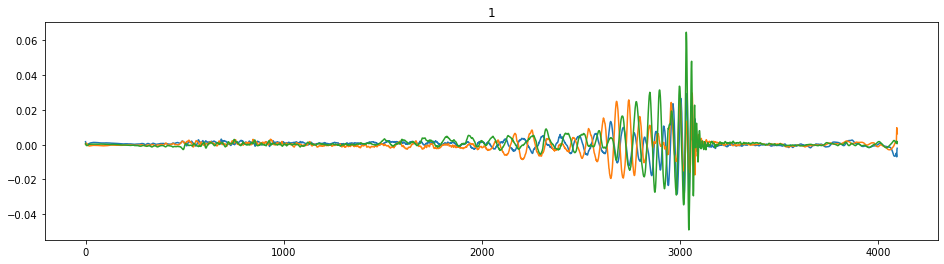

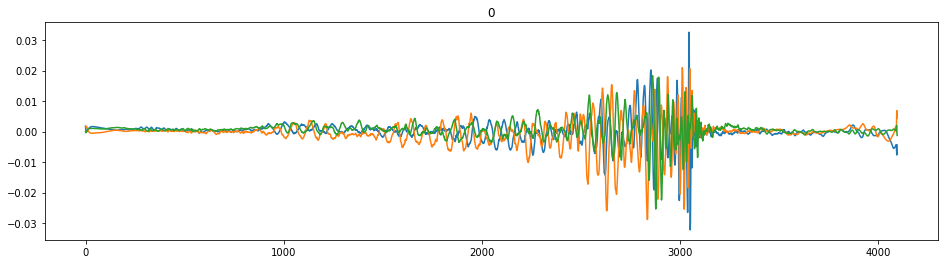

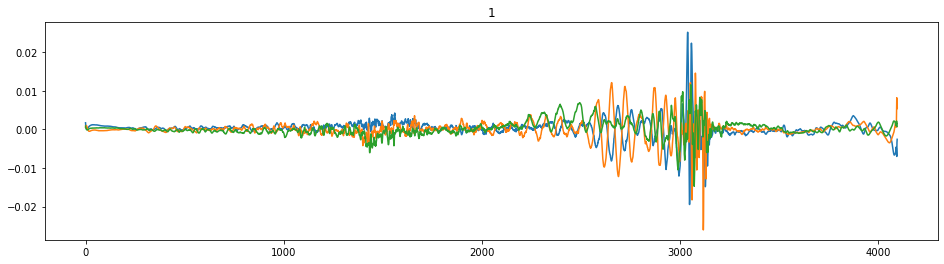

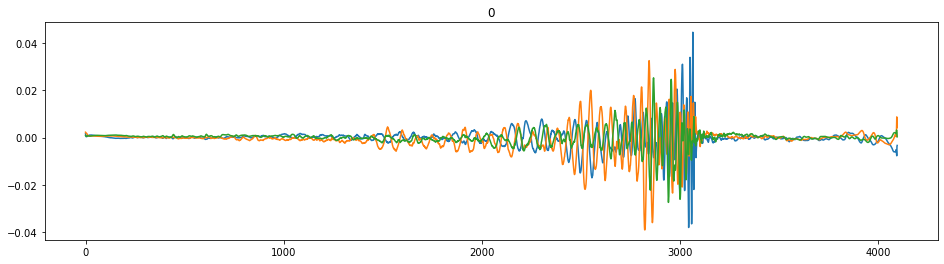

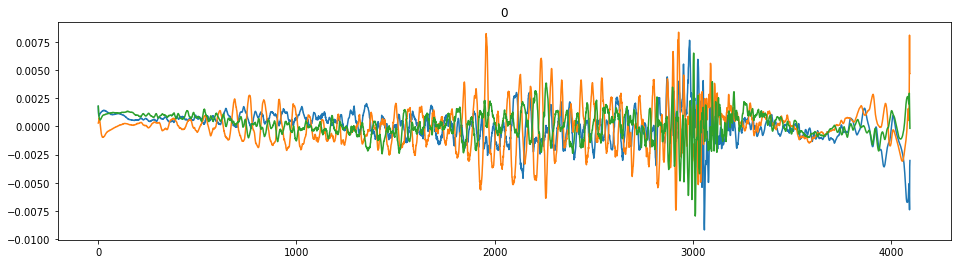

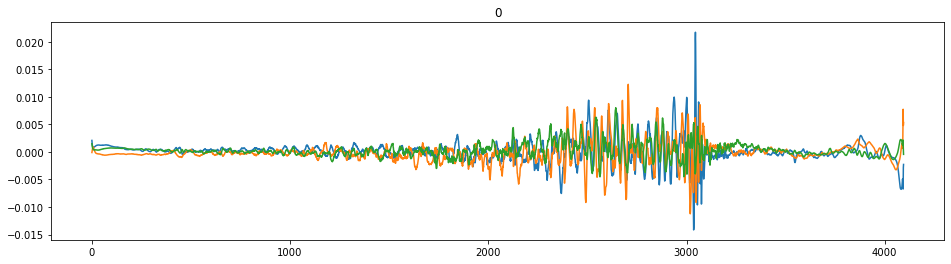

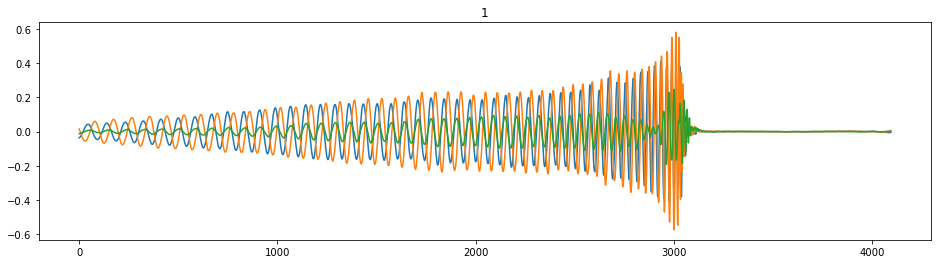

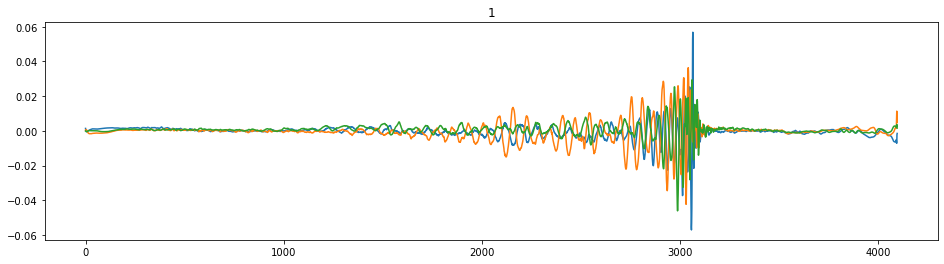

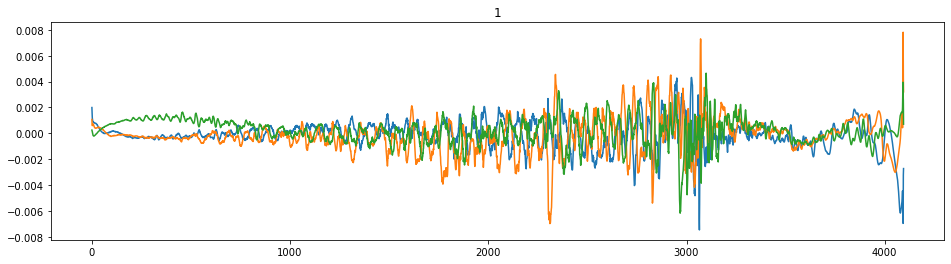

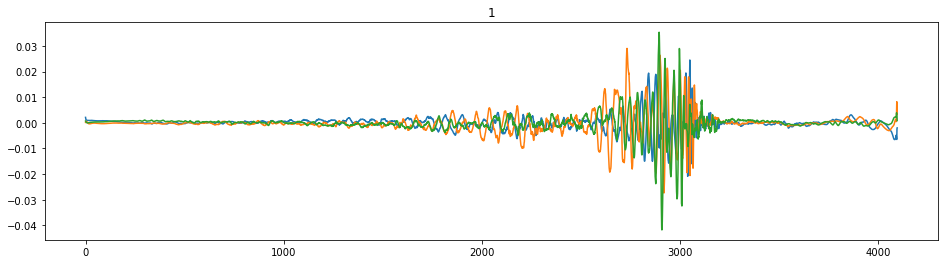

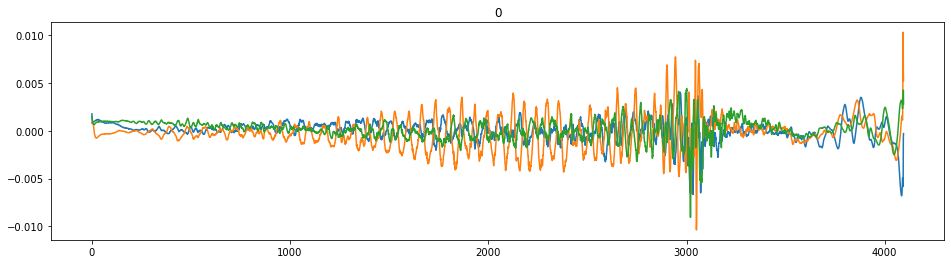

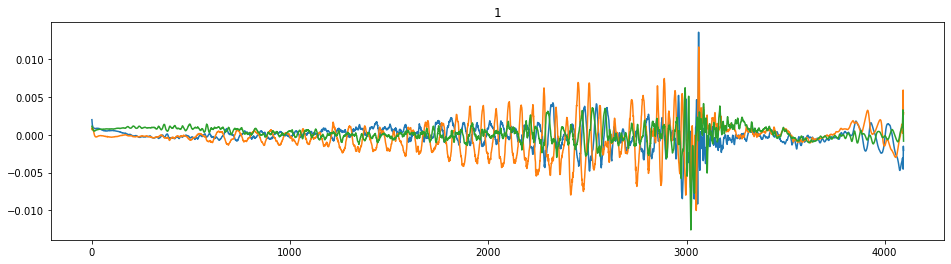

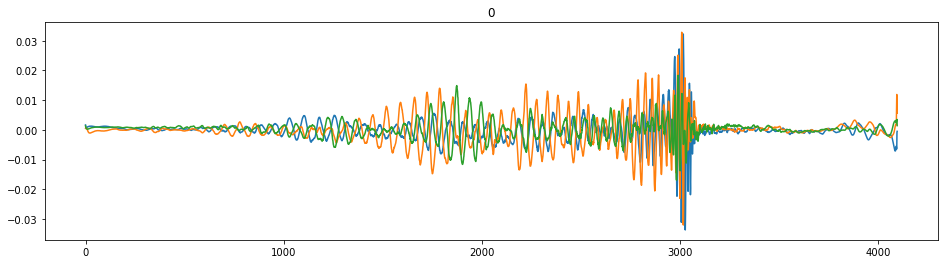

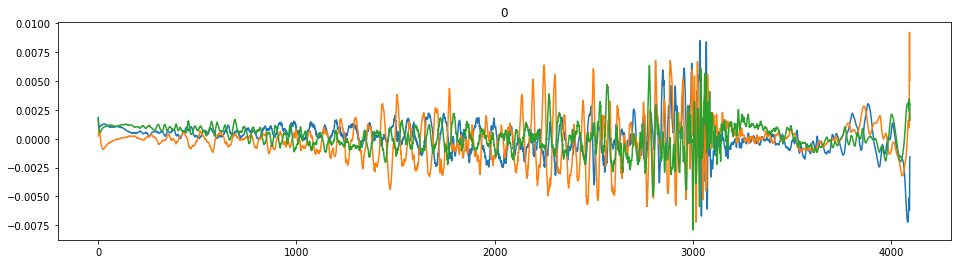

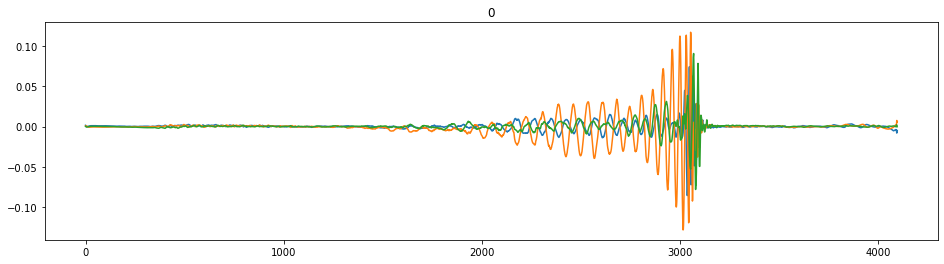

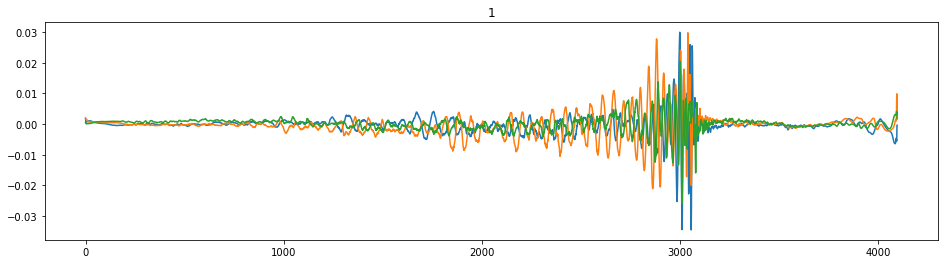

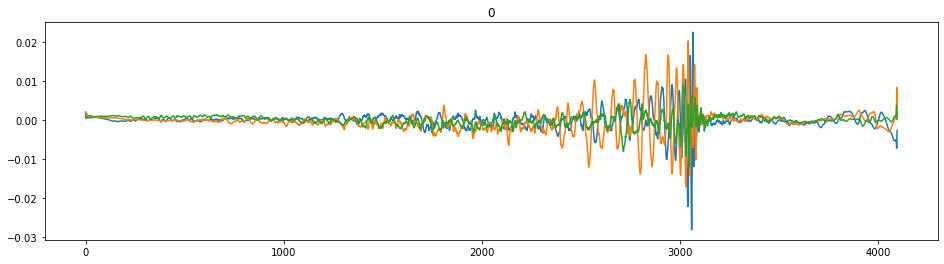

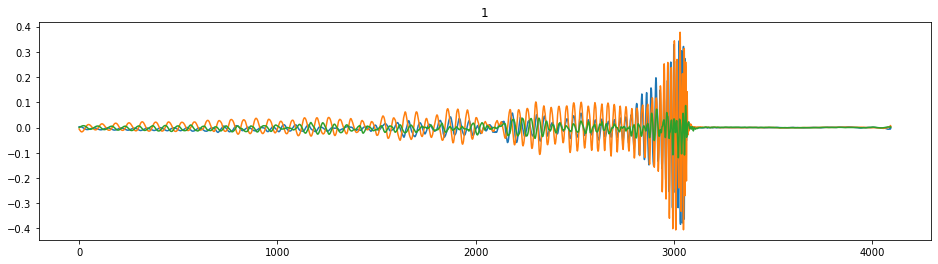

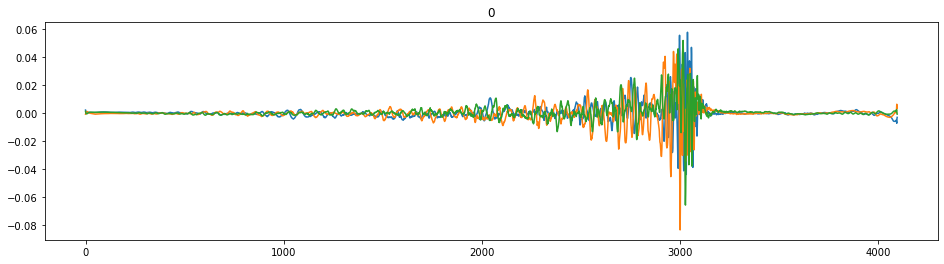

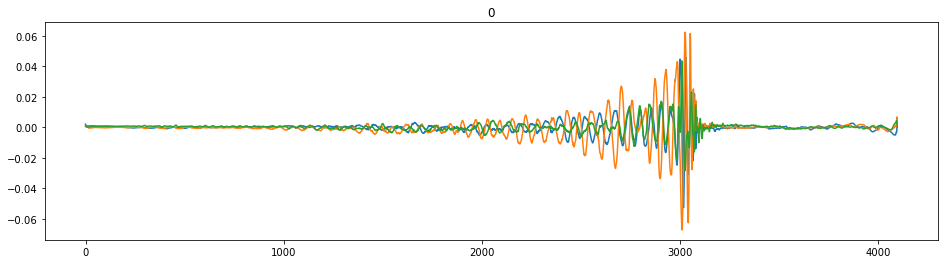

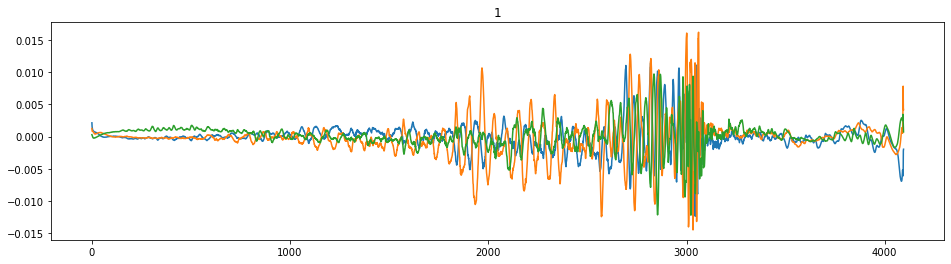

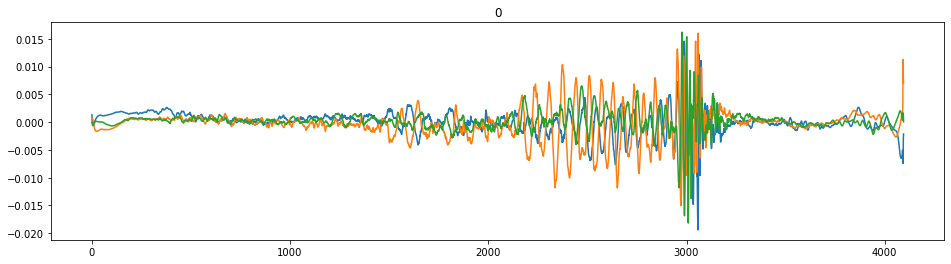

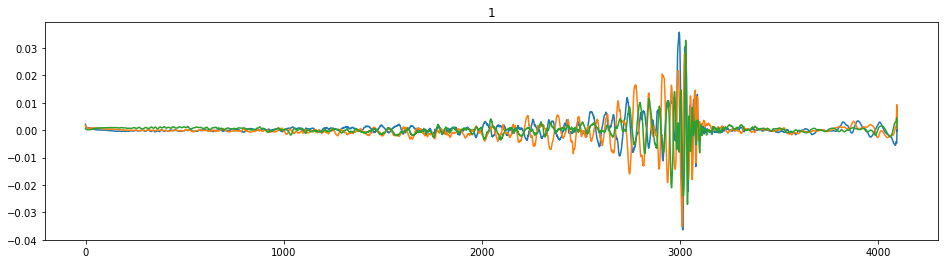

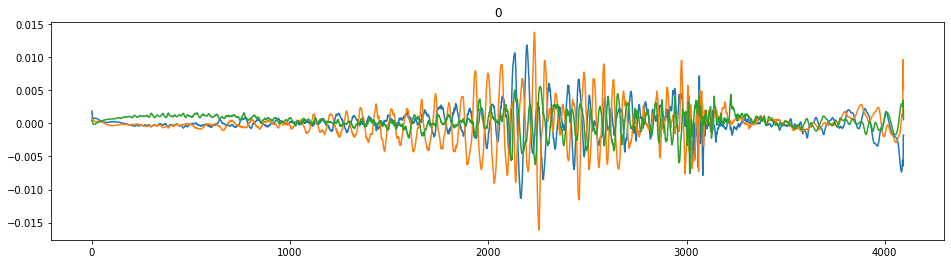

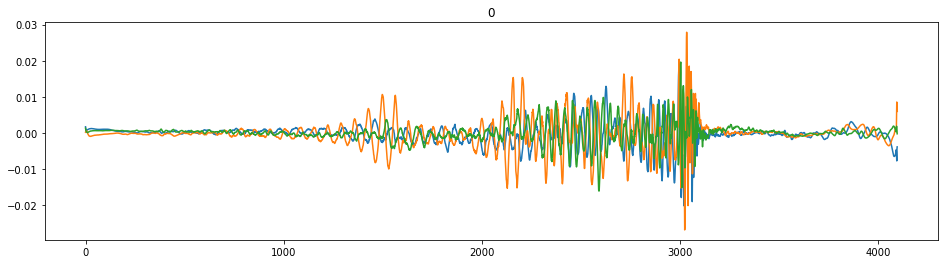

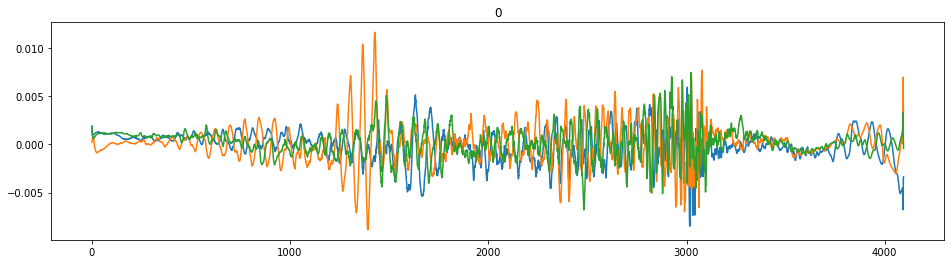

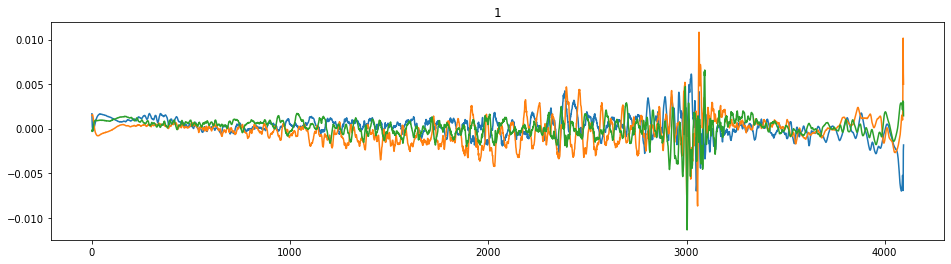

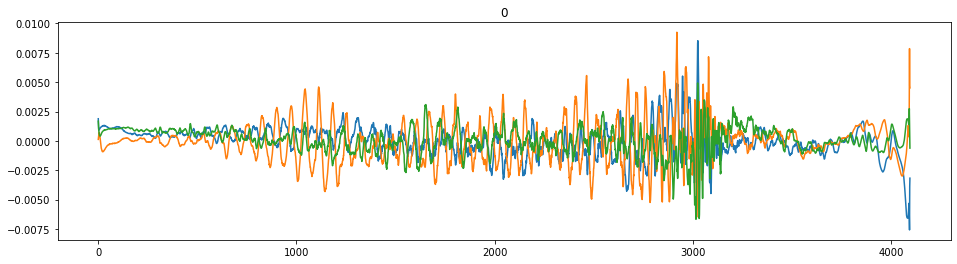

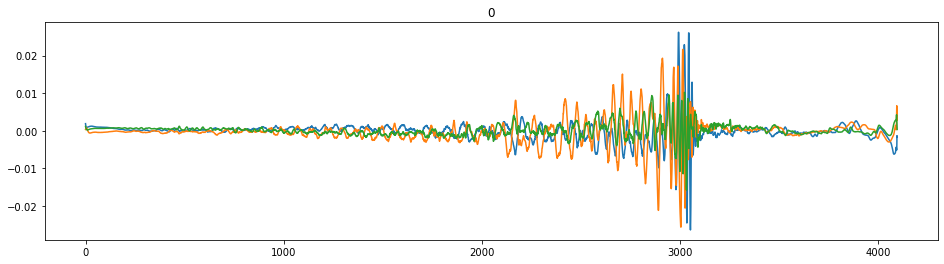

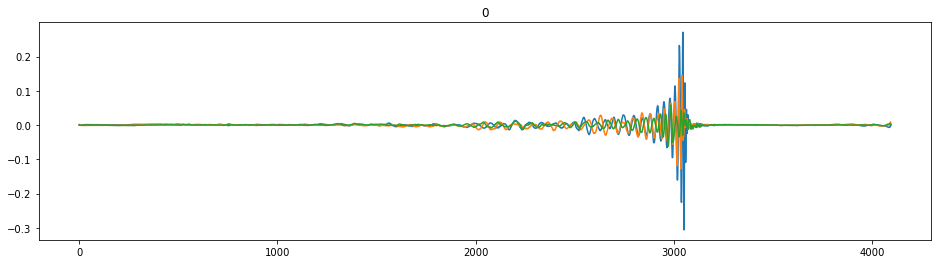

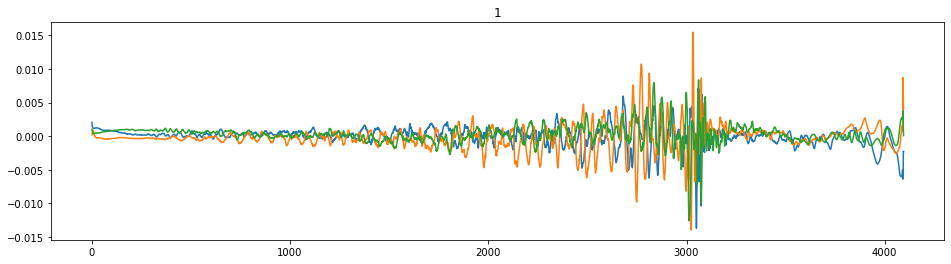

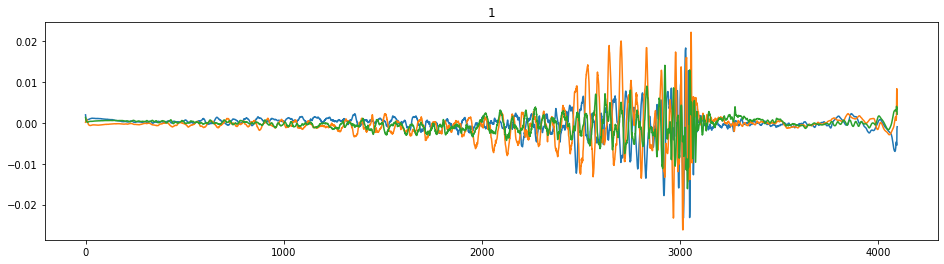

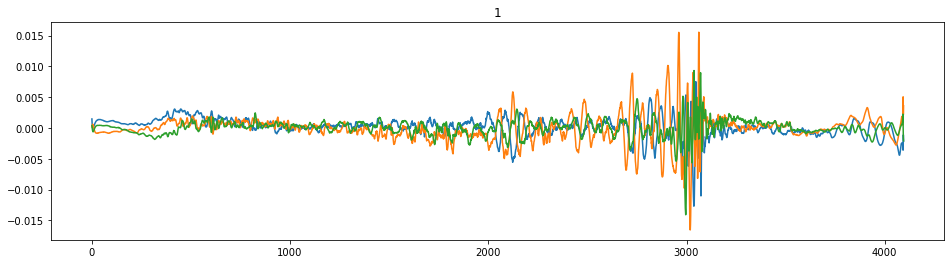

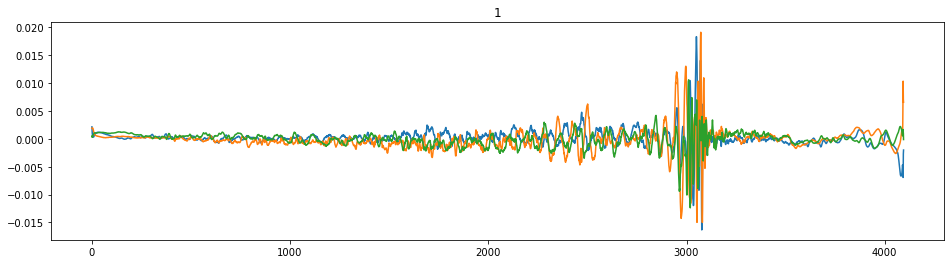

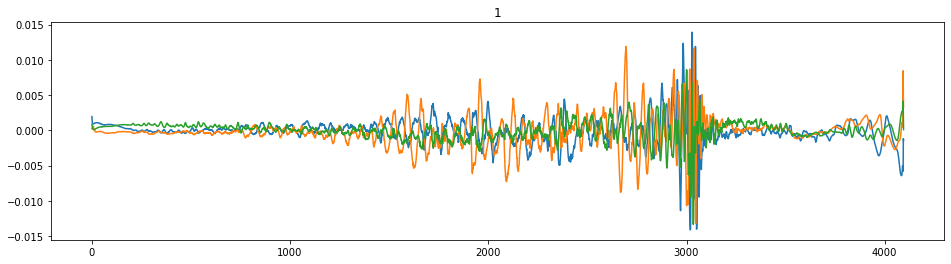

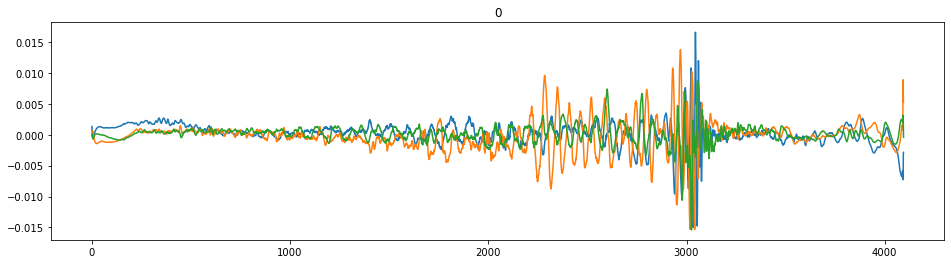

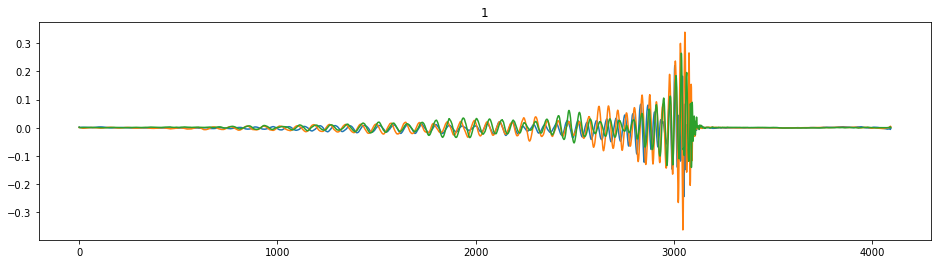

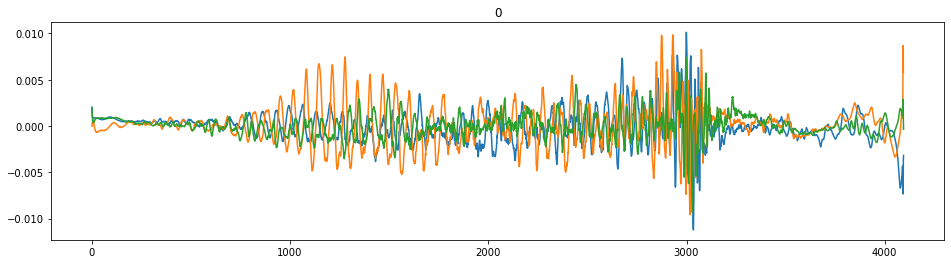

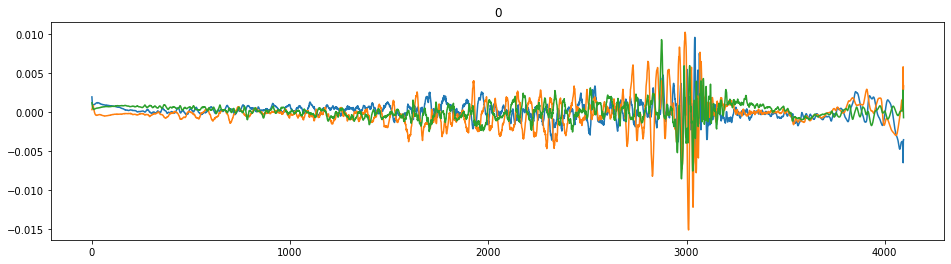

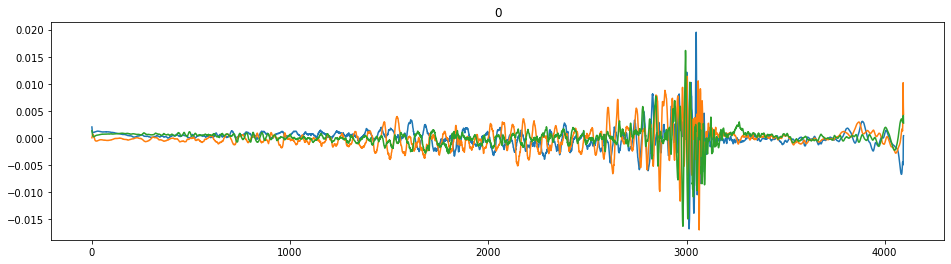

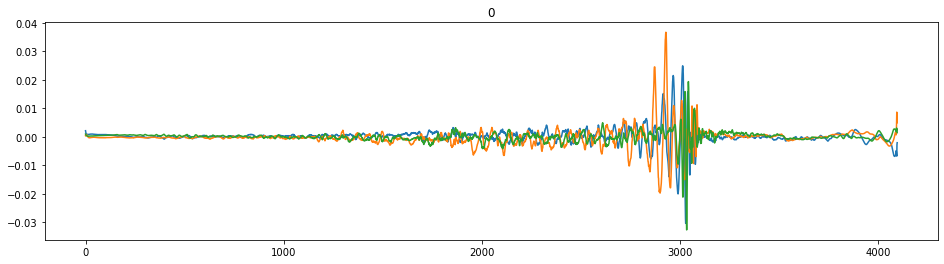

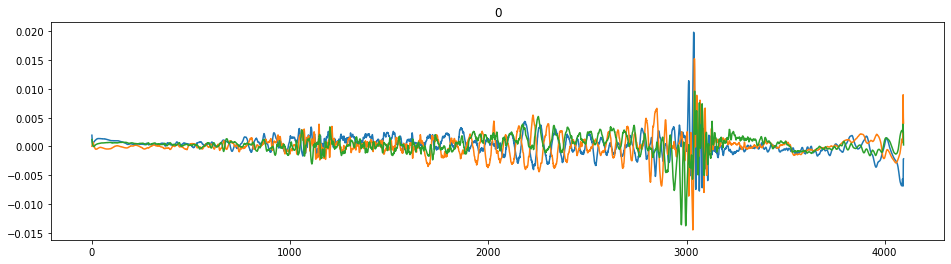

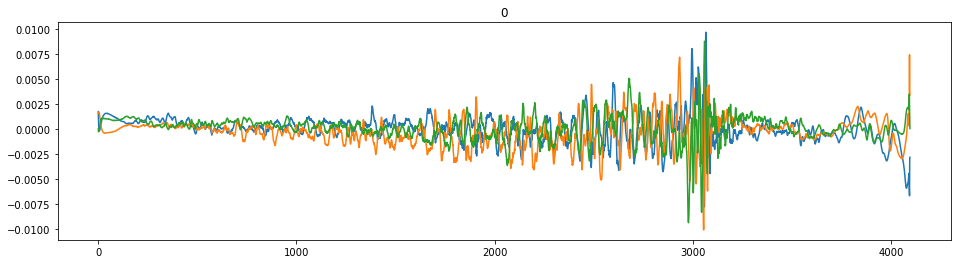

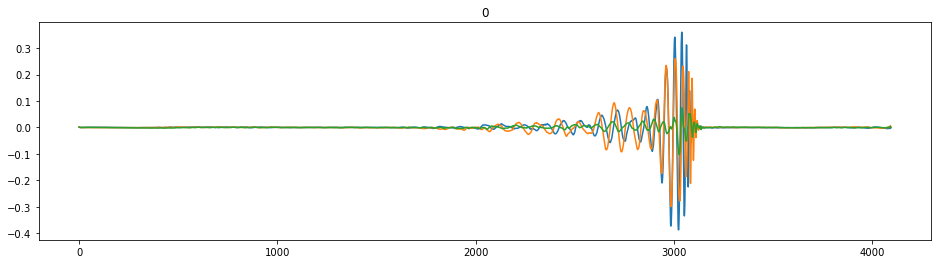

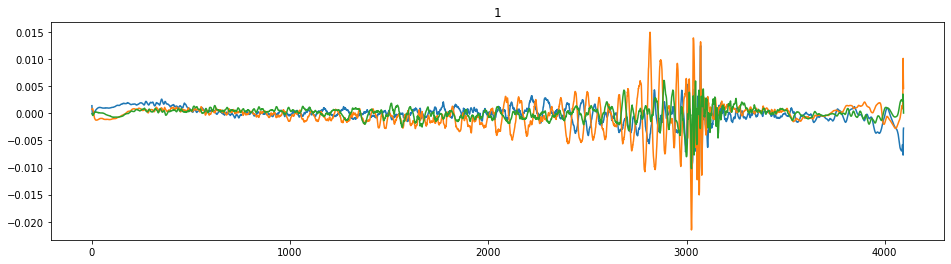

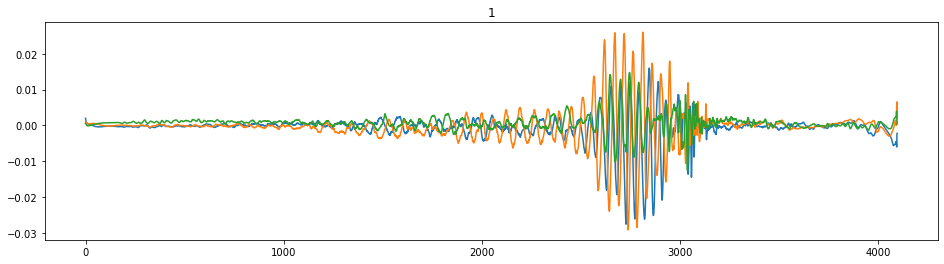

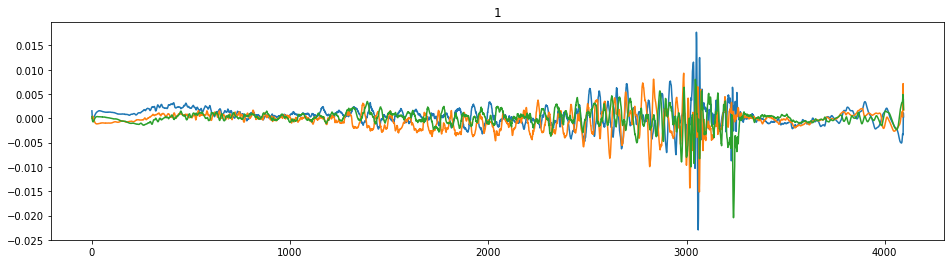

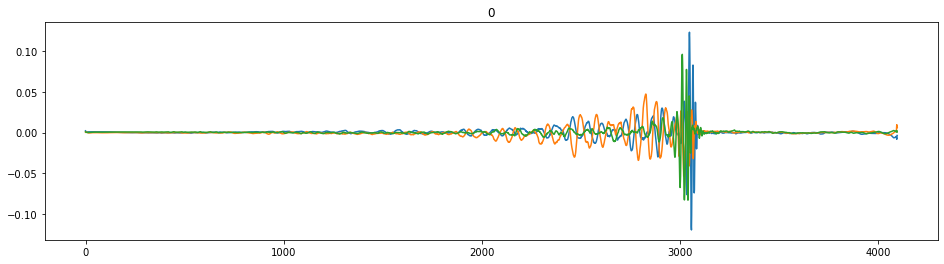

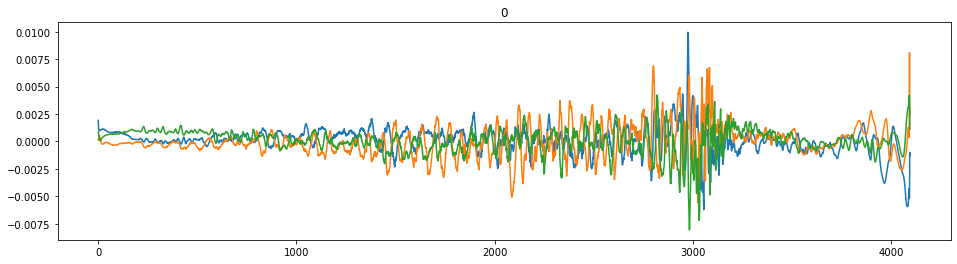

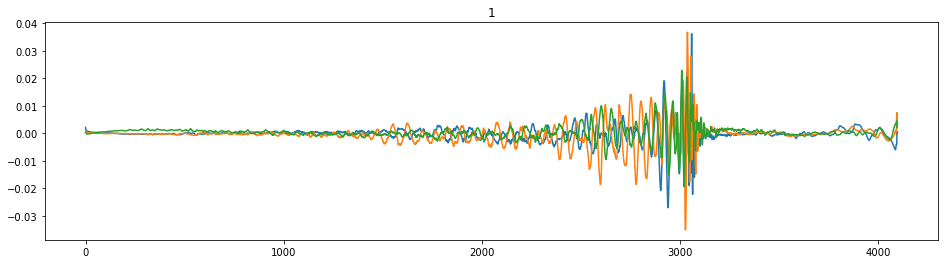

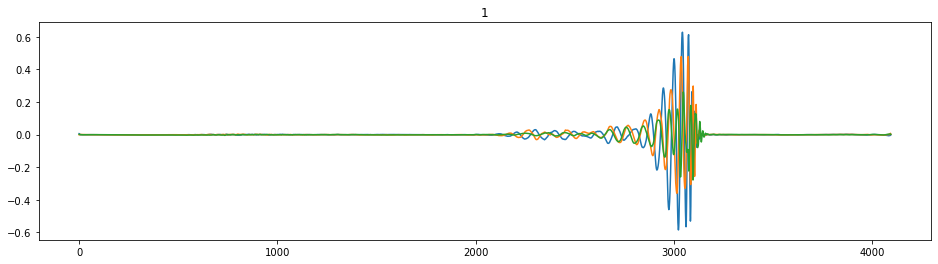

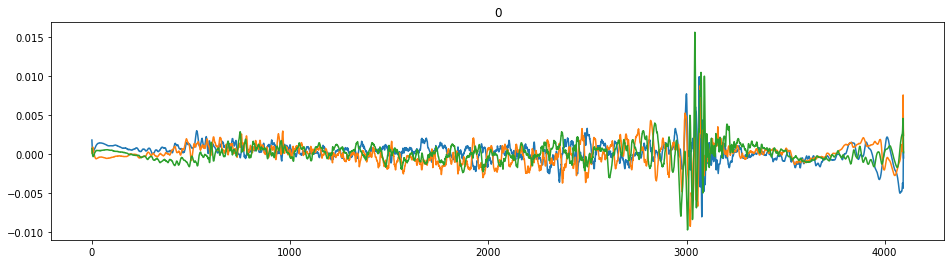

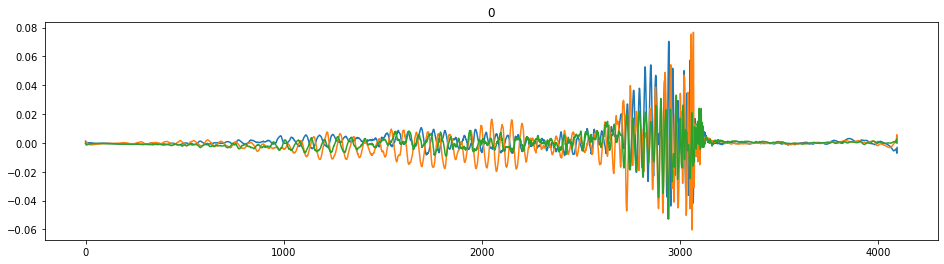

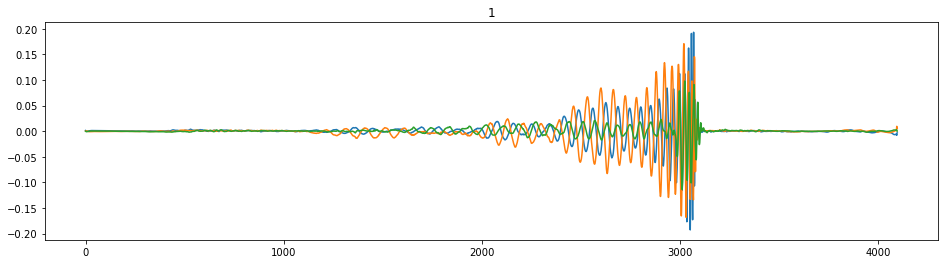

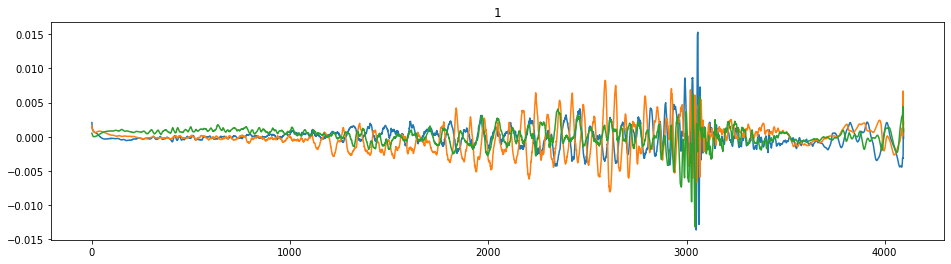

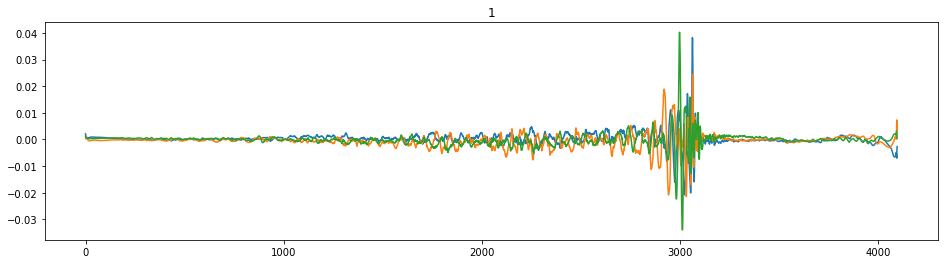

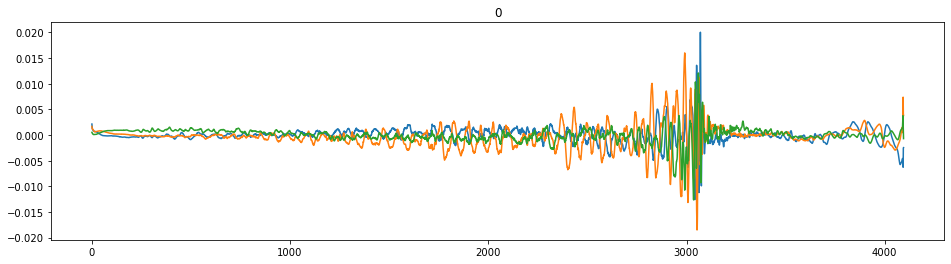

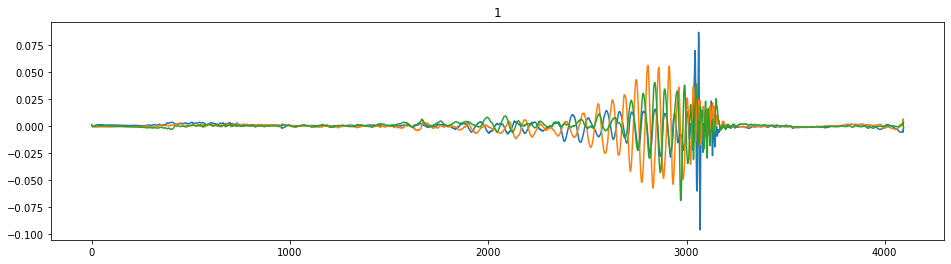

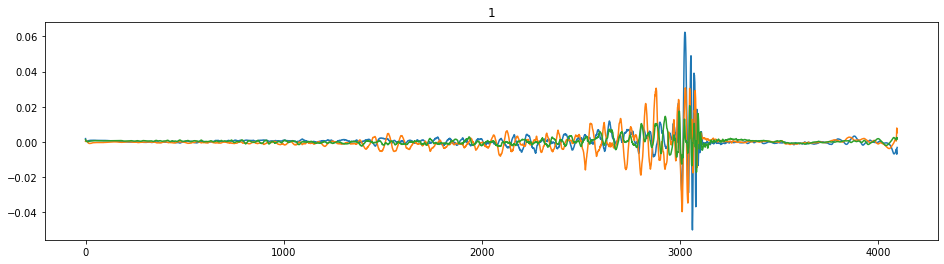

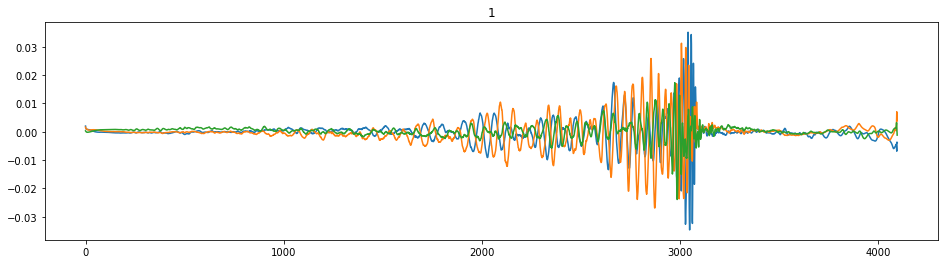

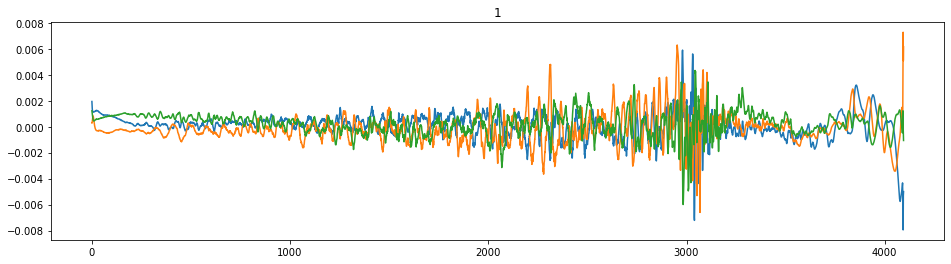

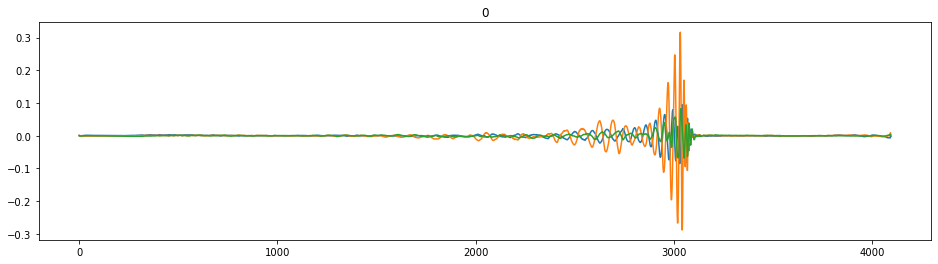

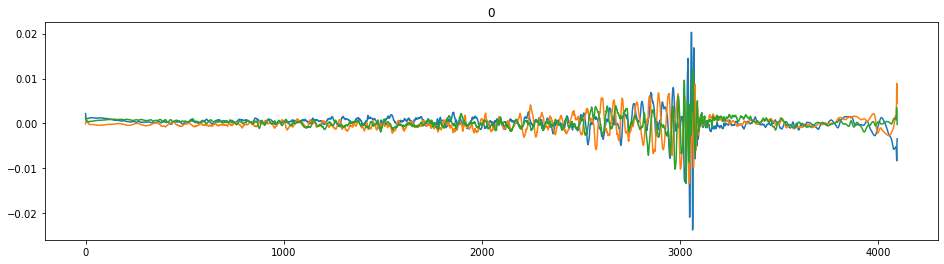

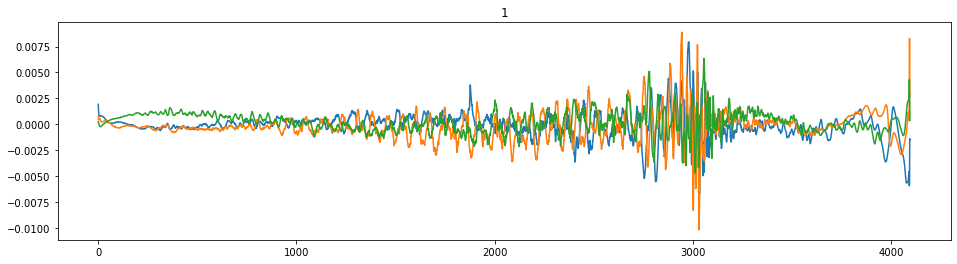

In [7]:
predictions = model.predict(vec[0])
# print(abs(predictions[vec[1]==1]).mean(),abs(predictions[vec[1]==0]).mean())
for i in range(64):
    plt.figure(figsize=(16,4))
    plt.plot(predictions[i])
#     plt.plot(vec[0][i])
    plt.title(vec[1][i].numpy())

    plt.show()